# CUSTOMER CHURN PREDICTION 

# Step-by-Step Implementation
We'll proceed with the following steps:

1. Import Libraries
2. Load and Explore the Dataset
3. Data Preprocessing
4. Feature Selection and Engineering
5. Train-Test Split
6. Dataset and DataLoader Creation
7. Model Definition
8. Loss Function and Optimizer
9. Training the Model
10. Evaluating the Model
11. Experimenting with Learning Rates and Model Complexity
12. Utilizing GPU Acceleration

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np

# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For visualization
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [4]:
# Load the dataset
data = pd.read_pickle('cleaned_churn_dataset.pkl')

# Display the first few rows
data.head()

,vintage,age,gender,dependents,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,...,previous_month_balance,churn,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student,customer_nw_category_1,customer_nw_category_2,customer_nw_category_3
0,2401,66,0,0,1458.71,1458.71,1458.71,1449.07,0.20,0.20,...,1458.71,0.0,0,0,0,1,0,0,1,0
1,2648,35,0,0,5390.37,8704.66,7799.26,12419.41,0.56,0.56,...,8787.61,0.0,0,0,0,1,0,0,1,0
2,2494,31,0,0,3913.16,5815.29,4910.17,2815.94,0.61,0.61,...,5070.14,0.0,0,0,1,0,0,0,1,0
3,2629,90,0,1,2291.91,2291.91,2084.54,1006.54,0.47,0.47,...,1669.79,1.0,0,0,0,1,0,0,1,0
4,1879,42,0,2,927.72,1401.72,1643.31,1871.12,0.33,714.61,...,1677.16,1.0,0,0,0,1,0,0,0,1


In [5]:
# Check for missing values
print('\nMissing values in each column:')
print(data.isnull().sum())


Missing values in each column:
vintage                           0
age                               0
gender                            0
dependents                        0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
occupation_company                0
occupation_retired                0
occupation_salaried               0
occupation_self_employed          0
occupation_student                0
customer_nw_category_1            0
customer_nw_category_2            0
customer_nw_category_3            0
dtype: int64


# 4. Feature Selection and Engineering
Select Features and Normalize Numerical Columns

In [8]:
# Define features and target variable
features = data.drop(['churn'], axis=1)
target = data['churn']

# Fill missing values if any (example: fill with median for numerical columns)
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Encode categorical variables using Label Encoding or One-Hot Encoding
categorical_cols = ['gender', 'occupation', 'city']

In [9]:
# Normalize numerical features
scaler = StandardScaler()
features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

# Convert features and target to NumPy arrays
X = features.values
y = target.values

# 5. Train-Test Split

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 12743
Testing samples: 3186


# 6. Dataset and DataLoader Creation

In [ ]:
# Create a custom Dataset class to handle our data
class ChurnDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Create Dataset instances
train_dataset = ChurnDataset(X_train, y_train)
test_dataset = ChurnDataset(X_test, y_test)

# Define batch size for loading data
batch_size = 64

# Create DataLoader objects to handle batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# 7. Model Definition

In [ ]:
# Define a neural network model by subclassing nn.Module
class ChurnModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()  # Initialize the base class
        # First fully connected layer (input layer to hidden layer)
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()           # Activation function
        
        # Second fully connected layer (hidden layer)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()           # Activation function
        
        # Third fully connected layer (hidden layer to output layer)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()      # Sigmoid activation for binary classification
    
    def forward(self, x):
        # Define the forward pass through the network
        out = self.fc1(x)                # Pass input through first layer
        out = self.relu1(out)            # Apply activation function
        out = self.fc2(out)              # Pass through second layer
        out = self.relu2(out)            # Apply activation function
        out = self.fc3(out)              # Pass through third layer
        out = self.sigmoid(out)          # Apply sigmoid activation
        return out                       # Return the output

In [ ]:
# Get the number of input features
input_size = X_train.shape[1]

# Instantiate the model and move it to the specified device (CPU or GPU)
model = ChurnModel(input_size).to(device)

In [36]:
print(model)

ChurnModel(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# 8. Loss Function and Optimizer

In [13]:
# Define the loss function (Binary Cross Entropy for binary classification)
criterion = nn.BCELoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate can be adjusted here for experimentation

# 9. Training the Model

In [ ]:
# Set the number of epochs (full passes over the training data)
num_epochs = 20

model.train()    # Set the model to training mode

In [ ]:
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0                       # Initialize epoch loss
    for features_batch, labels_batch in train_loader:
        # Move features and labels to the device
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device).unsqueeze(1)  # Reshape labels
        
        # Forward pass: compute the model's predictions
        outputs = model(features_batch)
        
        # Compute the loss between predicted and true labels
        loss = criterion(outputs, labels_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()            # Clear previous gradients
        loss.backward()                  # Compute gradients
        optimizer.step()                 # Update model parameters
        
        # Accumulate the loss over the epoch
        epoch_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')  # Print progress


In [40]:
# Initialize lists to store training history
num_epochs = 20
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    correct = 0
    total = 0
    
    for features_batch, labels_batch in train_loader:
        # Move data to the device
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device).unsqueeze(1)
        
        # Forward pass
        outputs = model(features_batch)
        loss = criterion(outputs, labels_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
        
        # Compute number of correct predictions
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels_batch).sum().item()
        total += labels_batch.size(0)
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    training_accuracy = correct / total
    training_accuracies.append(training_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {training_accuracy:.4f}')
    
    # Validation after each epoch
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_features_batch, val_labels_batch in test_loader:
            # Move data to the device
            val_features_batch = val_features_batch.to(device)
            val_labels_batch = val_labels_batch.to(device).unsqueeze(1)
            
            # Forward pass
            val_outputs = model(val_features_batch)
            val_loss_batch = criterion(val_outputs, val_labels_batch)
            val_loss += val_loss_batch.item()
            
            # Compute number of correct predictions
            val_predicted = (val_outputs >= 0.5).float()
            val_correct += (val_predicted == val_labels_batch).sum().item()
            val_total += val_labels_batch.size(0)
    
    # Calculate average validation loss and accuracy
    val_avg_loss = val_loss / len(test_loader)
    val_accuracy = val_correct / val_total
    validation_losses.append(val_avg_loss)
    validation_accuracies.append(val_accuracy)
    
    print(f'Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

Epoch [1/20], Loss: 0.3550, Accuracy: 0.8613
Validation Loss: 0.3916, Validation Accuracy: 0.8440

Epoch [2/20], Loss: 0.3493, Accuracy: 0.8611
Validation Loss: 0.3897, Validation Accuracy: 0.8459

Epoch [3/20], Loss: 0.3459, Accuracy: 0.8640
Validation Loss: 0.3889, Validation Accuracy: 0.8484

Epoch [4/20], Loss: 0.3478, Accuracy: 0.8651
Validation Loss: 0.4017, Validation Accuracy: 0.8437

Epoch [5/20], Loss: 0.3462, Accuracy: 0.8635
Validation Loss: 0.3924, Validation Accuracy: 0.8431

Epoch [6/20], Loss: 0.3448, Accuracy: 0.8671
Validation Loss: 0.3980, Validation Accuracy: 0.8434

Epoch [7/20], Loss: 0.3461, Accuracy: 0.8651
Validation Loss: 0.3957, Validation Accuracy: 0.8471

Epoch [8/20], Loss: 0.3404, Accuracy: 0.8670
Validation Loss: 0.3908, Validation Accuracy: 0.8462

Epoch [9/20], Loss: 0.3408, Accuracy: 0.8660
Validation Loss: 0.3853, Validation Accuracy: 0.8493

Epoch [10/20], Loss: 0.3390, Accuracy: 0.8674
Validation Loss: 0.3899, Validation Accuracy: 0.8509

Epoch [11

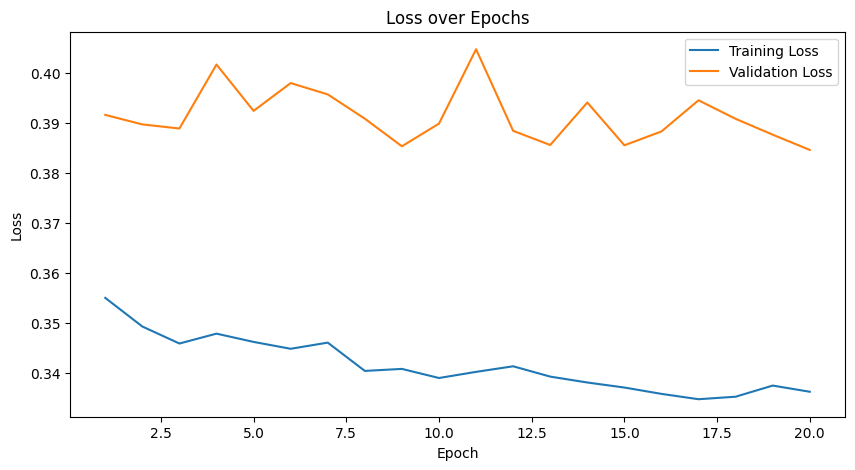

In [41]:
# After training, plot the loss and accuracy curves
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

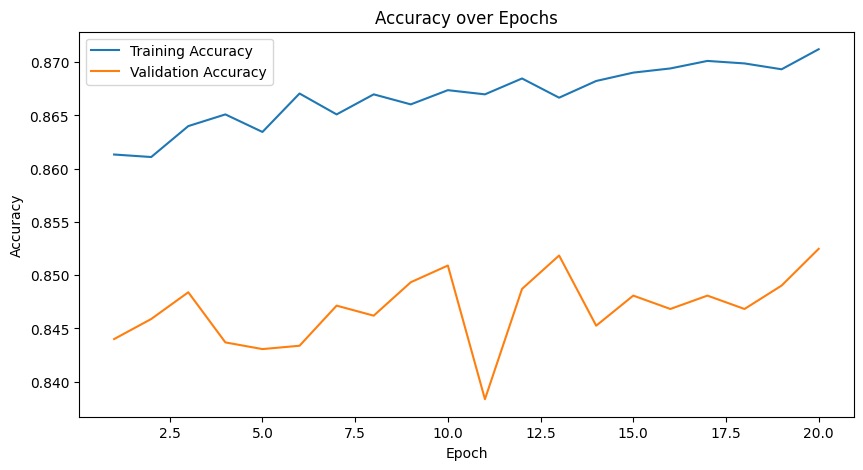

In [42]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# 10. Evaluating the Model

In [ ]:
# Set the model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation during evaluation for efficiency
with torch.no_grad():
    for features_batch, labels_batch in test_loader:
        # Move features and labels to the device
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device).unsqueeze(1)
        
        # Forward pass: compute predictions
        outputs = model(features_batch)
        
        # Apply threshold to get predicted classes (0 or 1)
        predicted = (outputs >= 0.5).float()
        
        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

In [ ]:
# Convert lists to NumPy arrays for evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
# Calculate accuracy of the model on the test set
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

In [19]:
# Classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      2589
         1.0       0.64      0.30      0.41       597

    accuracy                           0.84      3186
   macro avg       0.75      0.63      0.66      3186
weighted avg       0.82      0.84      0.81      3186



In [20]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('\nConfusion Matrix:')
print(cm)


Confusion Matrix:
[[2489  100]
 [ 417  180]]


In [26]:
!pip install seaborn --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


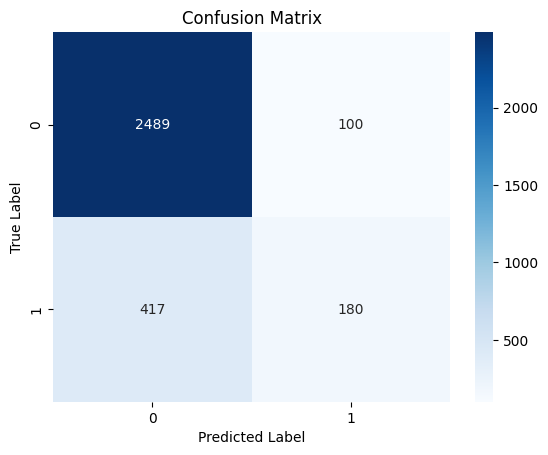

In [27]:
# Optional: Visualize the confusion matrix as a heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 11. Experimenting with Learning Rates and Model Complexity

In [21]:
# Experiment with a different learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

In [22]:
# Adding More Layers
# Modify the model by adding more layers or changing layer sizes
class ComplexChurnModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

In [23]:
# Instantiate the more complex model
complex_model = ComplexChurnModel(input_size).to(device)

# Use the same criterion and optimizer (or try different ones)
criterion = nn.BCELoss()
optimizer = optim.Adam(complex_model.parameters(), lr=0.001)

# 12. Utilizing GPU Acceleration

In [24]:
# Ensure that data and models are moved to the GPU if available
# This is already done in previous steps by moving data and model to 'device'

# Example:
features_batch = features_batch.to(device)
labels_batch = labels_batch.to(device)
model = model.to(device)

# 13. Model Visualization

In [28]:
!pip install torchsummary --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [29]:
from torchsummary import summary

input_size = X_train.shape[1]  # Replace with your actual input size
model = ChurnModel(input_size).to(device)

# Get the model summary
summary(model, input_size=(input_size,), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,472
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
           Sigmoid-6                    [-1, 1]               0
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [30]:
!pip install torchinfo --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


This will output a detailed summary, including:

- Layer hierarchy
- Output shapes at each layer
- Number of trainable and non-trainable parameters
- Total parameters and memory usage


In [31]:
from torchinfo import summary

input_size = X_train.shape[1]
batch_size = 1  # You can set this to any number

model = ChurnModel(input_size).to(device)

# Get the detailed model summary
summary(model, input_size=(batch_size, input_size), device=str(device))


Layer (type:depth-idx)                   Output Shape              Param #
ChurnModel                               [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   1,472
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
├─Sigmoid: 1-6                           [1, 1]                    --
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [34]:
# Define a dummy input tensor with the correct input size
dummy_input = torch.randn(1, input_size).to(device)

# Export the model to an ONNX file
torch.onnx.export(
    model,               # Your PyTorch model
    dummy_input,         # An example input tensor
    "churn_model.onnx",  # The file name to save the ONNX model
    input_names=['input'],   # Name of the input node
    output_names=['output'], # Name of the output node
    opset_version=11         # ONNX version
)


In [33]:
!pip install onnx --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


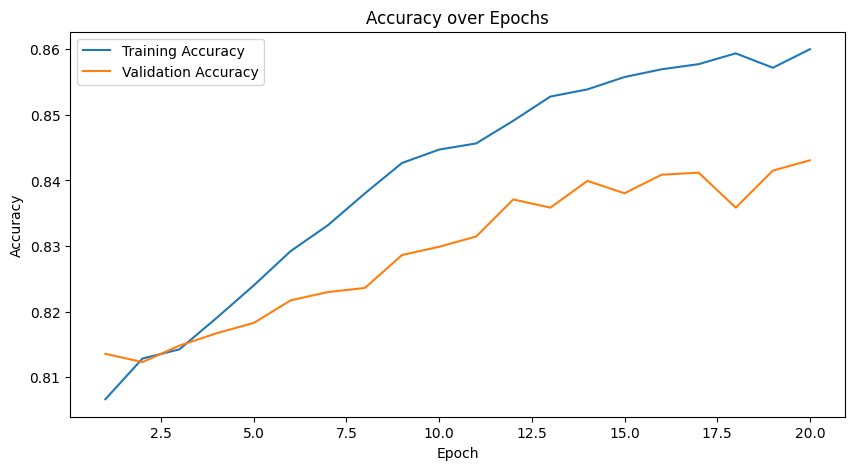